#### 使用RNN实现一个天气预测模型，能预测1天和连续5天的最高气温。要求使用tensorboard，提交代码及run目录和可视化截图。


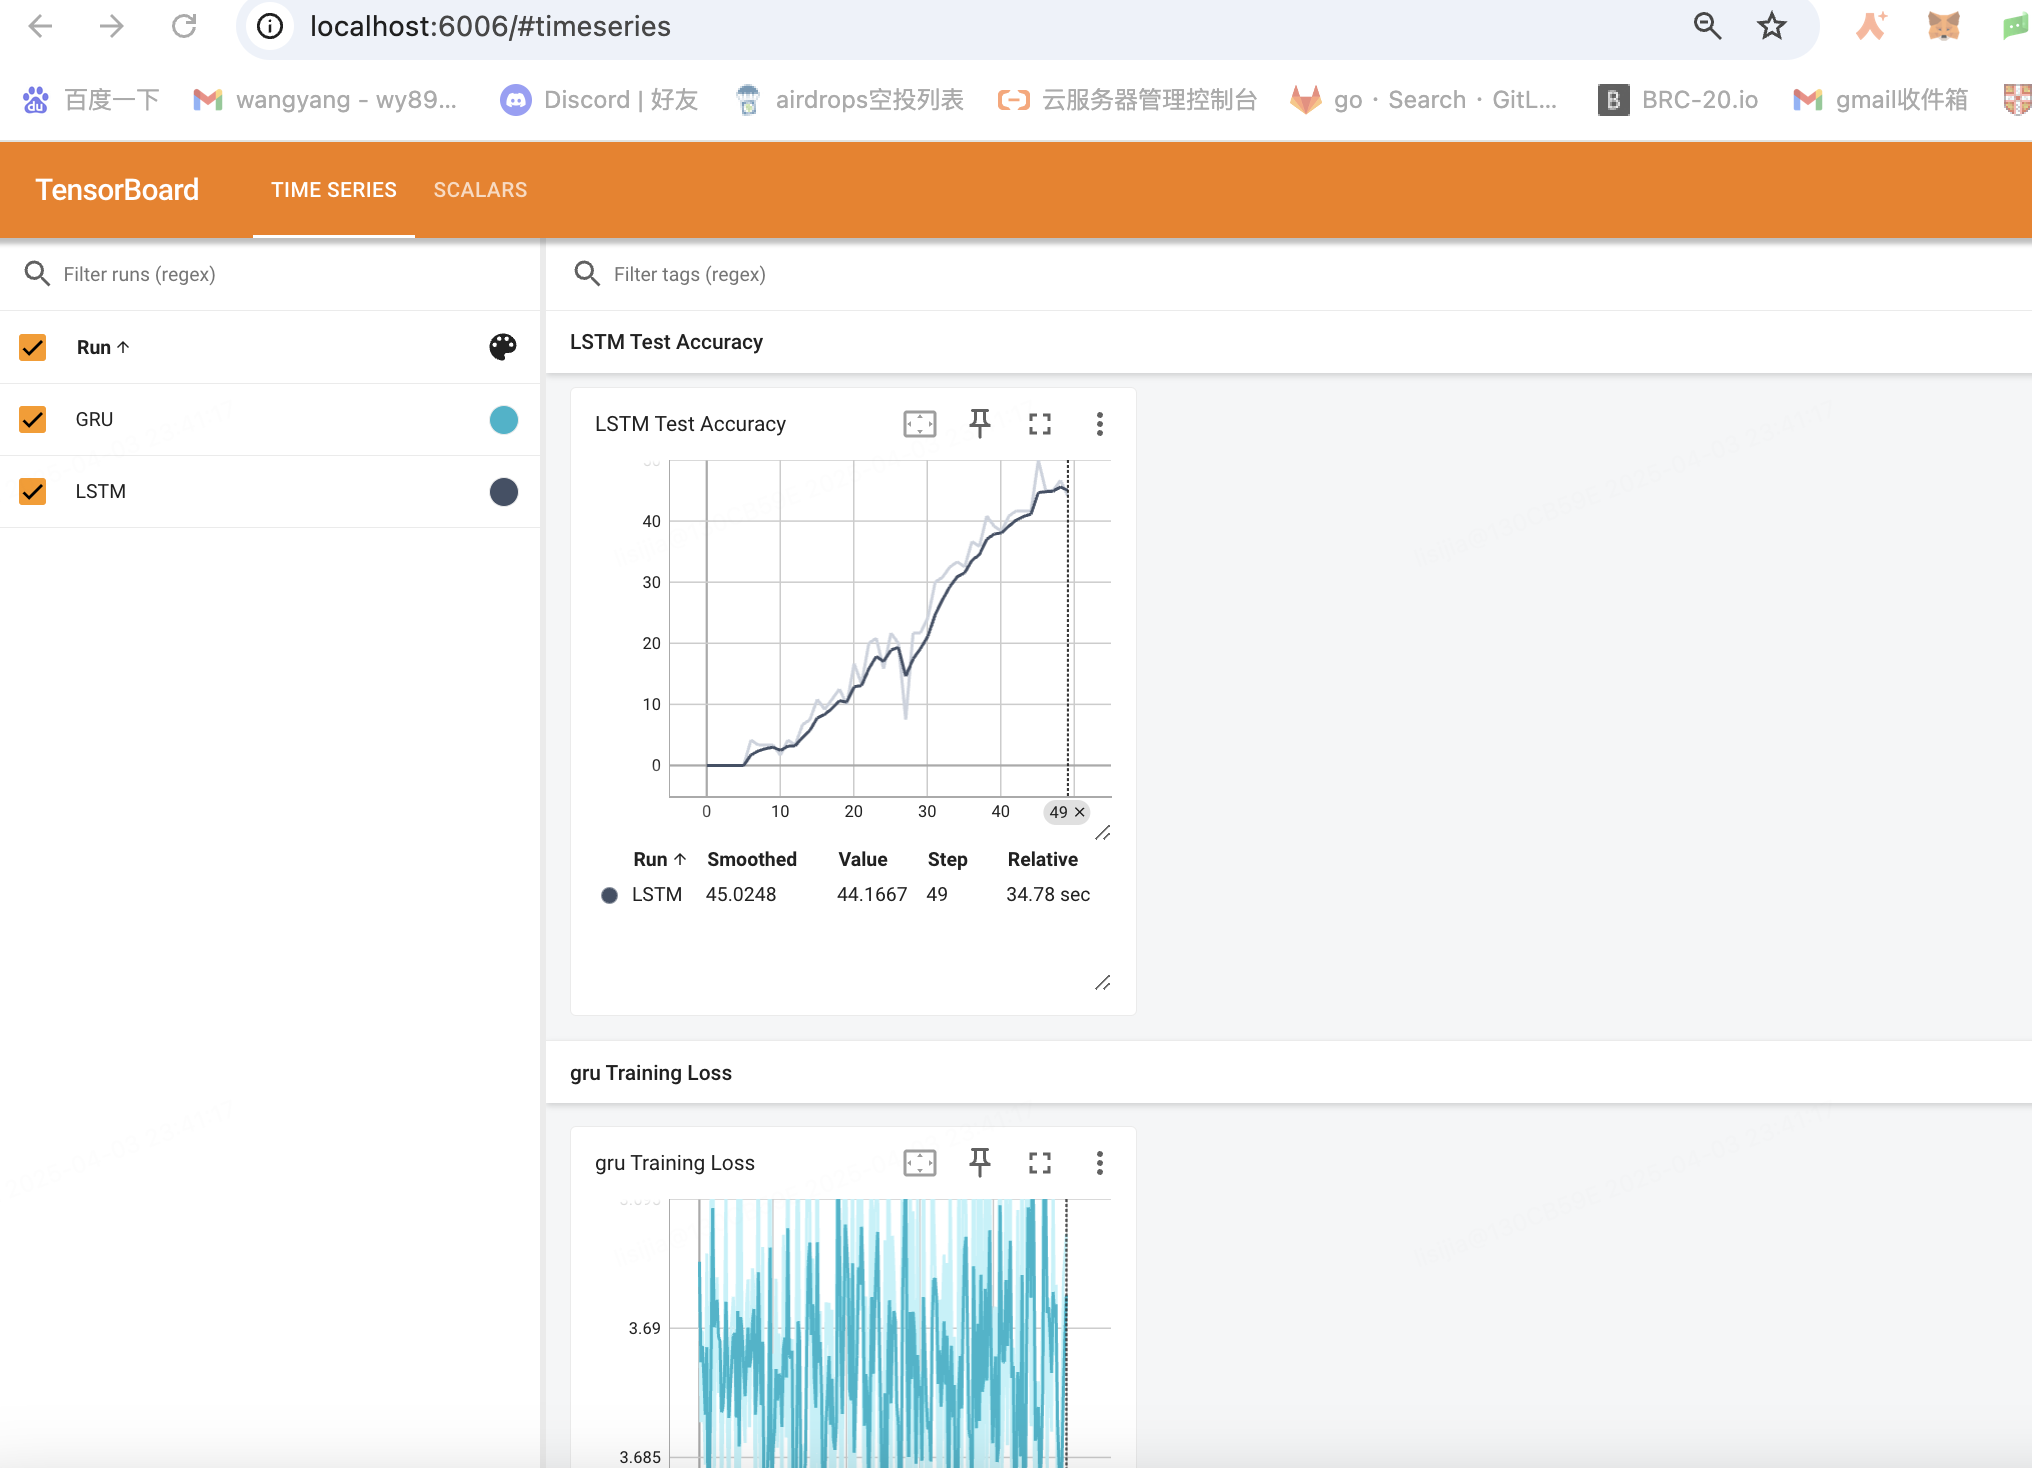

In [106]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd 



# Set the path to the file you'd like to load
file_path = "李思佳/week06/weatherww2"

path = kagglehub.dataset_download("smid80/weatherww2")

print("Path to dataset files:", path)

nRowsRead = 1000 # specify 'None' if want to read whole file
# Summary of Weather.csv has 119040 rows in reality, but we are only loading/previewing the first 1000 rows
# df1 = pd.read_csv('/Users/peiqi/code/AiPremiumClass/李思佳/week06/Summary of Weather.csv', delimiter=',', nrows = nRowsRead)
# df1.dataframeName = 'Summary of Weather.csv'
# nRow, nCol = df1.shape
# print(f'There are {nRow} rows and {nCol} columns')

data = pd.read_csv('/Users/peiqi/code/AiPremiumClass/李思佳/week06/Summary of Weather.csv')

# 转换日期格式
data['Date'] = pd.to_datetime(data['Date'])

# 选择特征
max_temp = data[['MaxTemp']]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_max_temp = scaler.fit_transform(max_temp)



Path to dataset files: /Users/peiqi/.cache/kagglehub/datasets/smid80/weatherww2/versions/1


In [107]:
# 创建时间序列数据
def create_sequences(data, time_steps=50, prediction_steps=1):  
    X, y = [], []
    for i in range(len(data) - time_steps - prediction_steps + 1):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[(i + time_steps):(i + time_steps + prediction_steps), 0])
    return np.array(X), np.array(y)


# 设置时间步长和预测步长
time_steps = 50
prediction_steps = 1  # 1 for 1-day prediction, 5 for 5-day prediction

X, y = create_sequences(scaled_max_temp, time_steps, prediction_steps)
X = X.astype(np.float32)
y = y.astype(np.float32)

# # 调整输入数据形状
# X = X.reshape((X.shape[0], X.shape[1], 1))

In [108]:
# time_steps = 50
# series = create_sequences(1000, time_steps + 1)
# X_train, y_train = series[:700, :time_steps], series[:700, -1]
# X_valid, y_valid = series[700:900, :time_steps], series[700:900, -1]
# X_test, y_test = series[900:, :time_steps], series[900:, -1]
# X_train.shape, y_train.shape



# 拆分训练集和测试集
train_size = int(len(X) * 0.7)
valid_size = int(len(X) * 0.8)
X_train,X_valid, X_test = X[:train_size], X[train_size:valid_size], X[valid_size:-1]
y_train, y_valid, y_test = y[:train_size], y[train_size:valid_size], y[valid_size:-1]

print(y_train[0])
X_train.shape, y_train.shape


# # 训练模型
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

[0.1923077]


((774, 50), (774, 1))

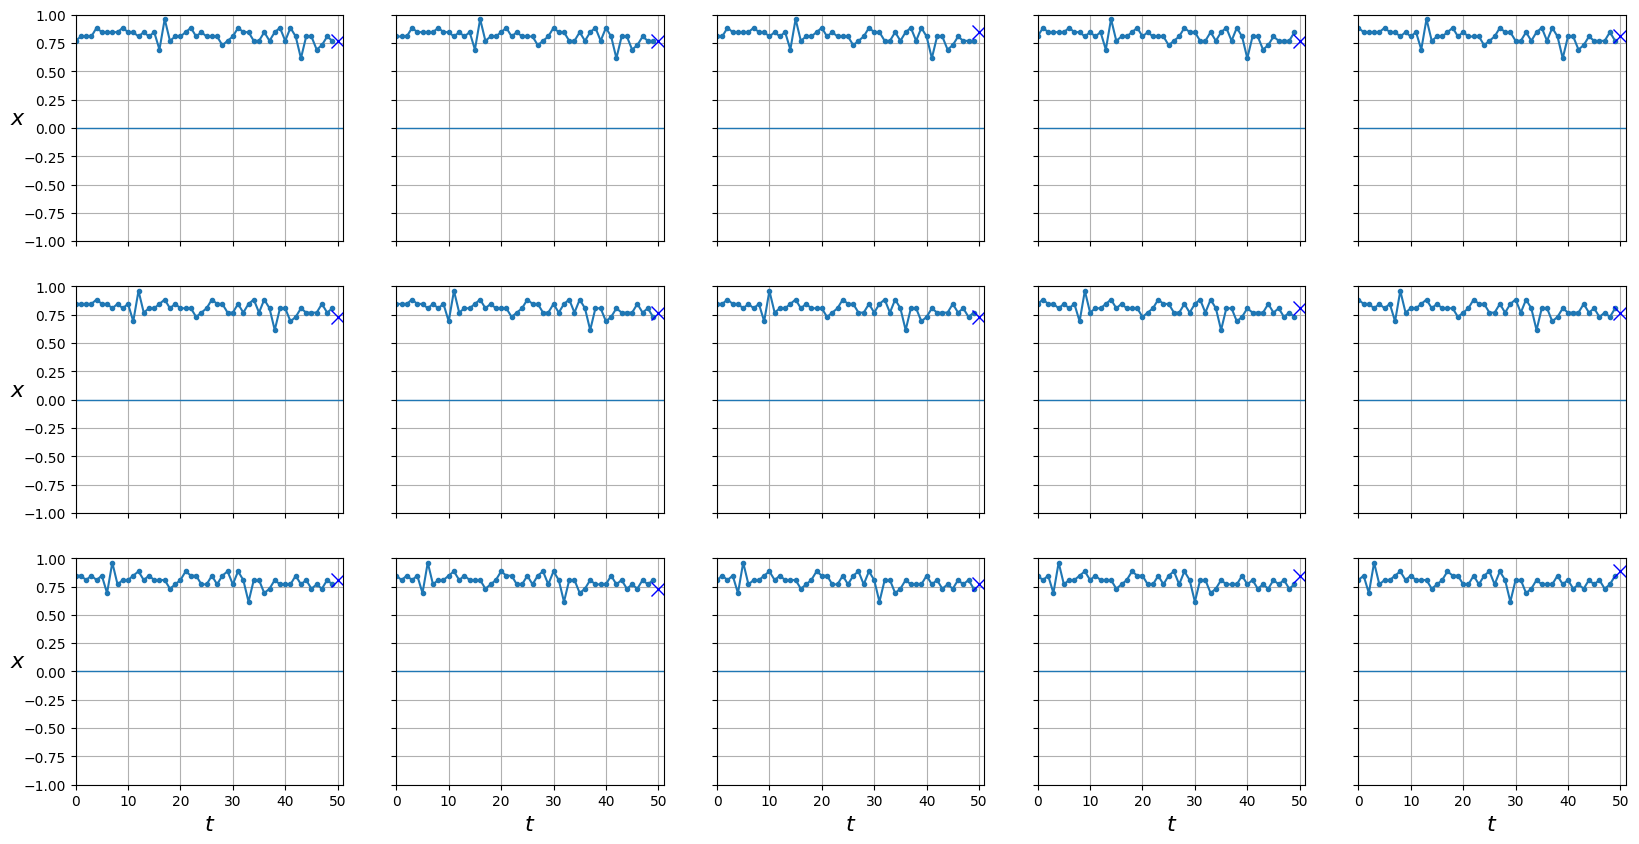

In [109]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row*c
            plt.plot(series[ix, :], ".-")
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            plt.hlines(0, 0, 100, linewidth=1)
            plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
            if x_label and row == r - 1:
              plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
              plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.show()

plot_series(X_test, y_test)

In [110]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])
  
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [111]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [112]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

device = "cuda" if torch.cuda.is_available() else "cpu"
writer = SummaryWriter(log_dir='/Users/peiqi/code/AiPremiumClass/李思佳/week06/logs/hw2')


def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)

            X = X.unsqueeze(-1)  # 添加这一行以调整 X 的形状

            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        writer.add_scalar('Loss/train', np.mean(train_loss), epoch)  # 记录训练损失
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                X = X.unsqueeze(-1)  # 添加这一行以调整 X 的形状

                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        
        writer.add_scalar('Loss/val', np.mean(eval_loss), epoch)  # 记录验证损失
        
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")

        writer.close()

        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            X = X.unsqueeze(-1)  # 添加这一行以调整 X 的形状
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [113]:
fit(rnn, dataloader)


loss 0.01708 val_loss 0.01497: 100%|██████████| 10/10 [00:00<00:00, 20.50it/s]


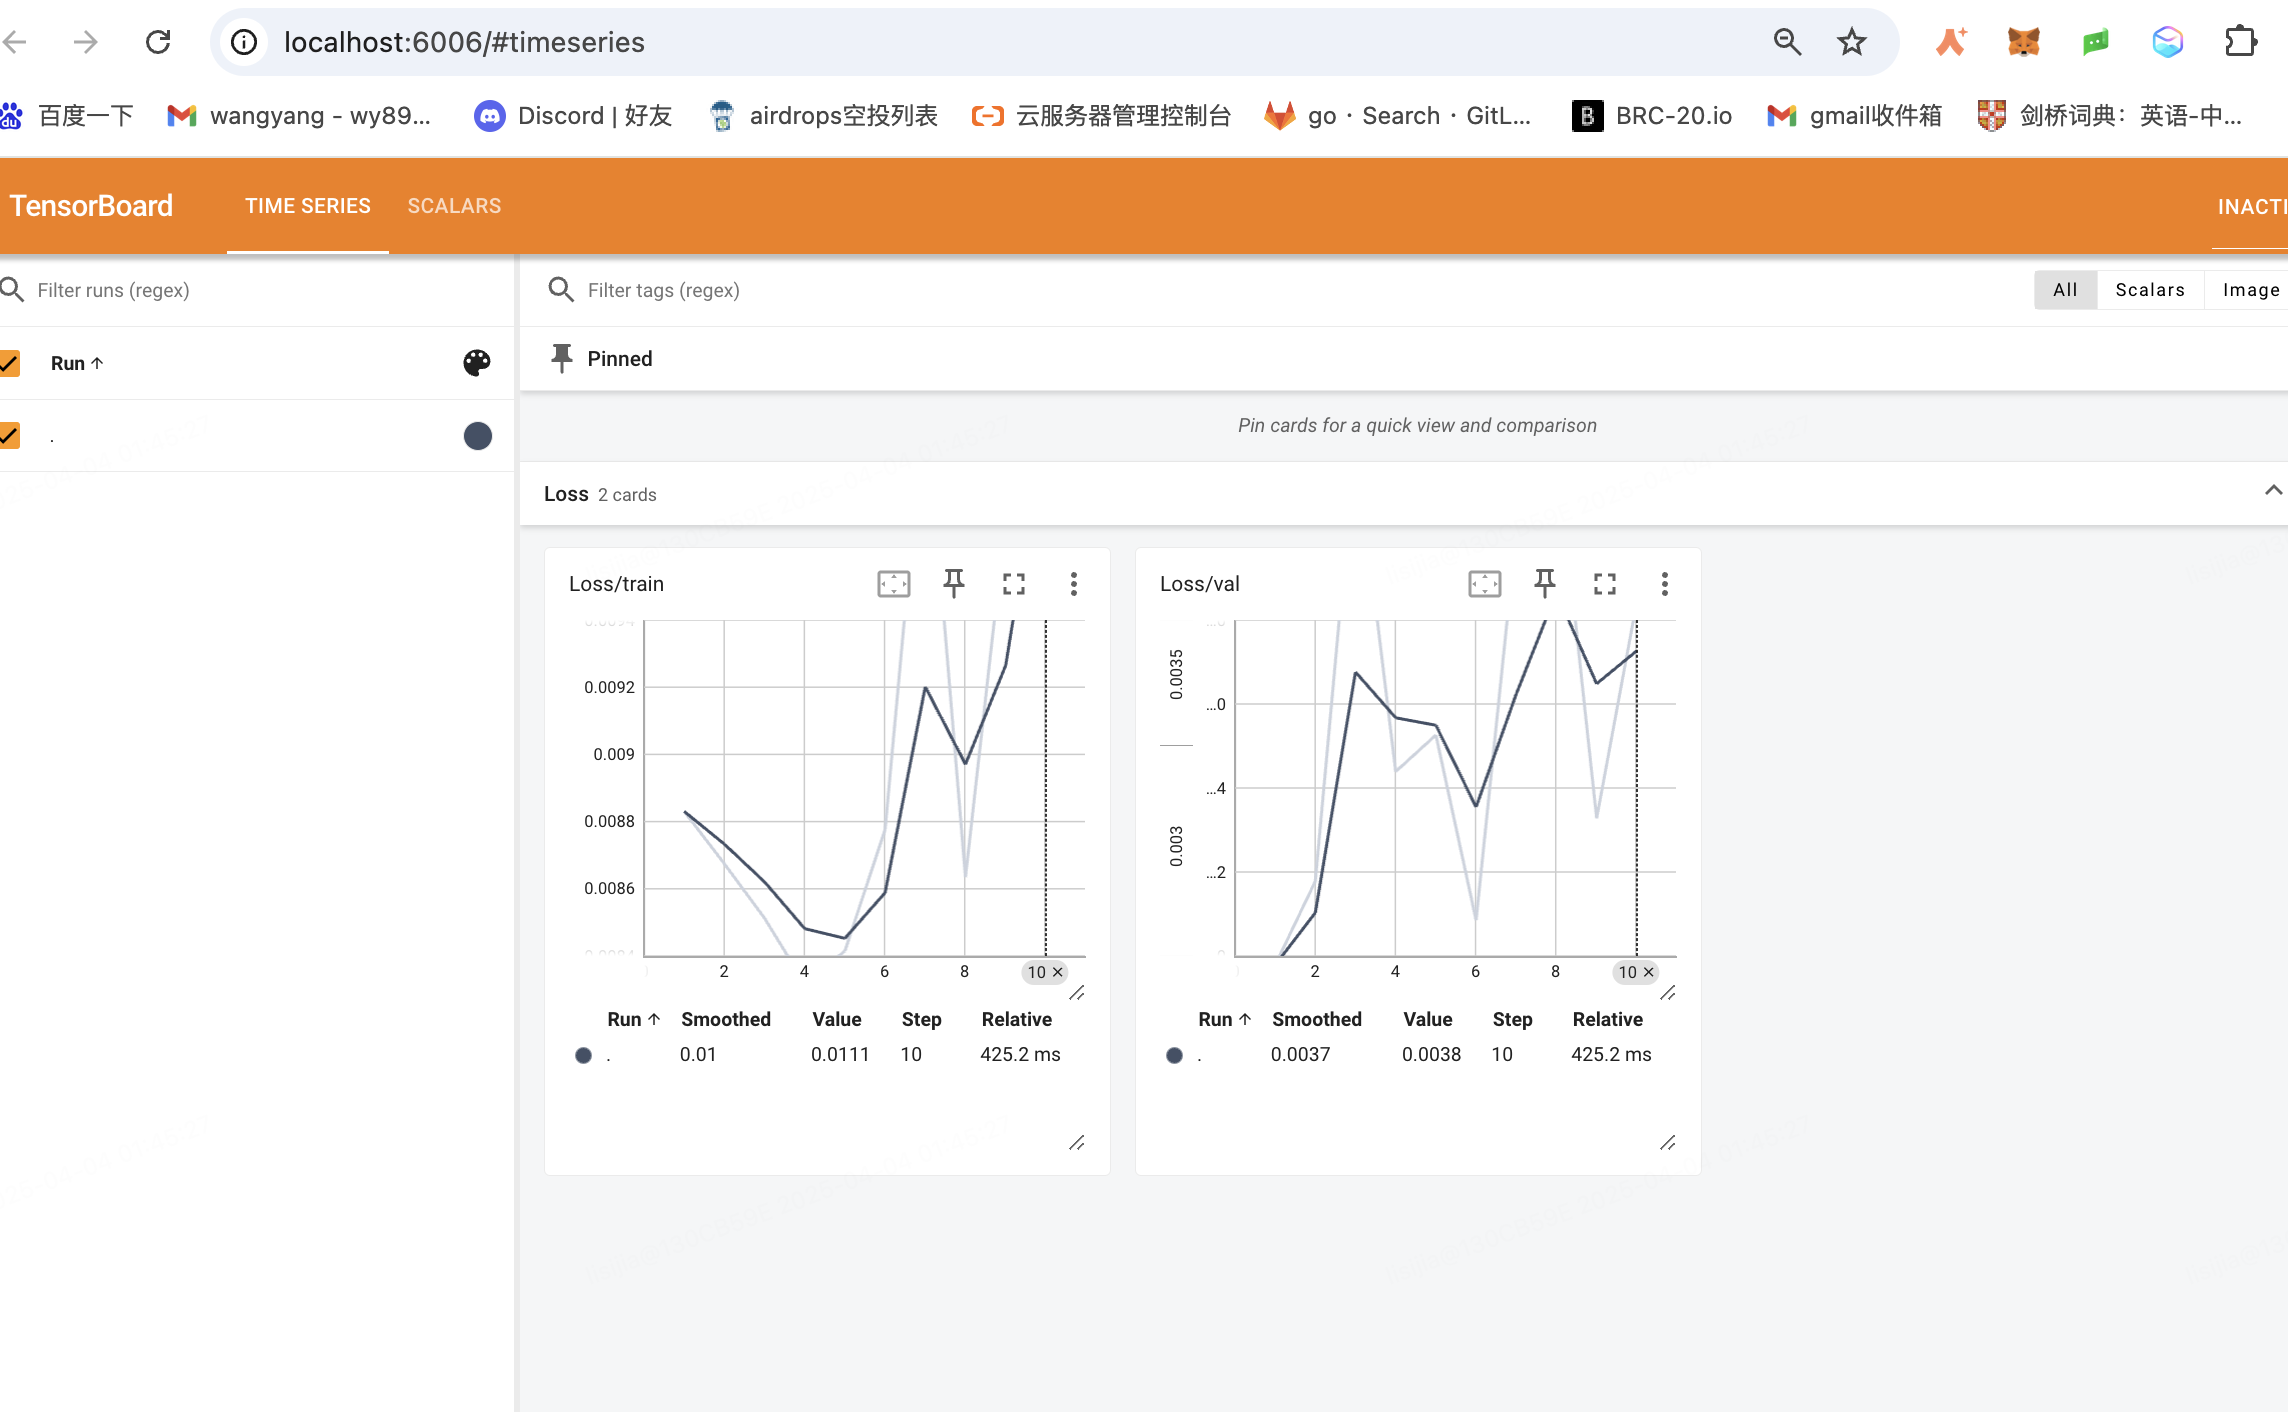

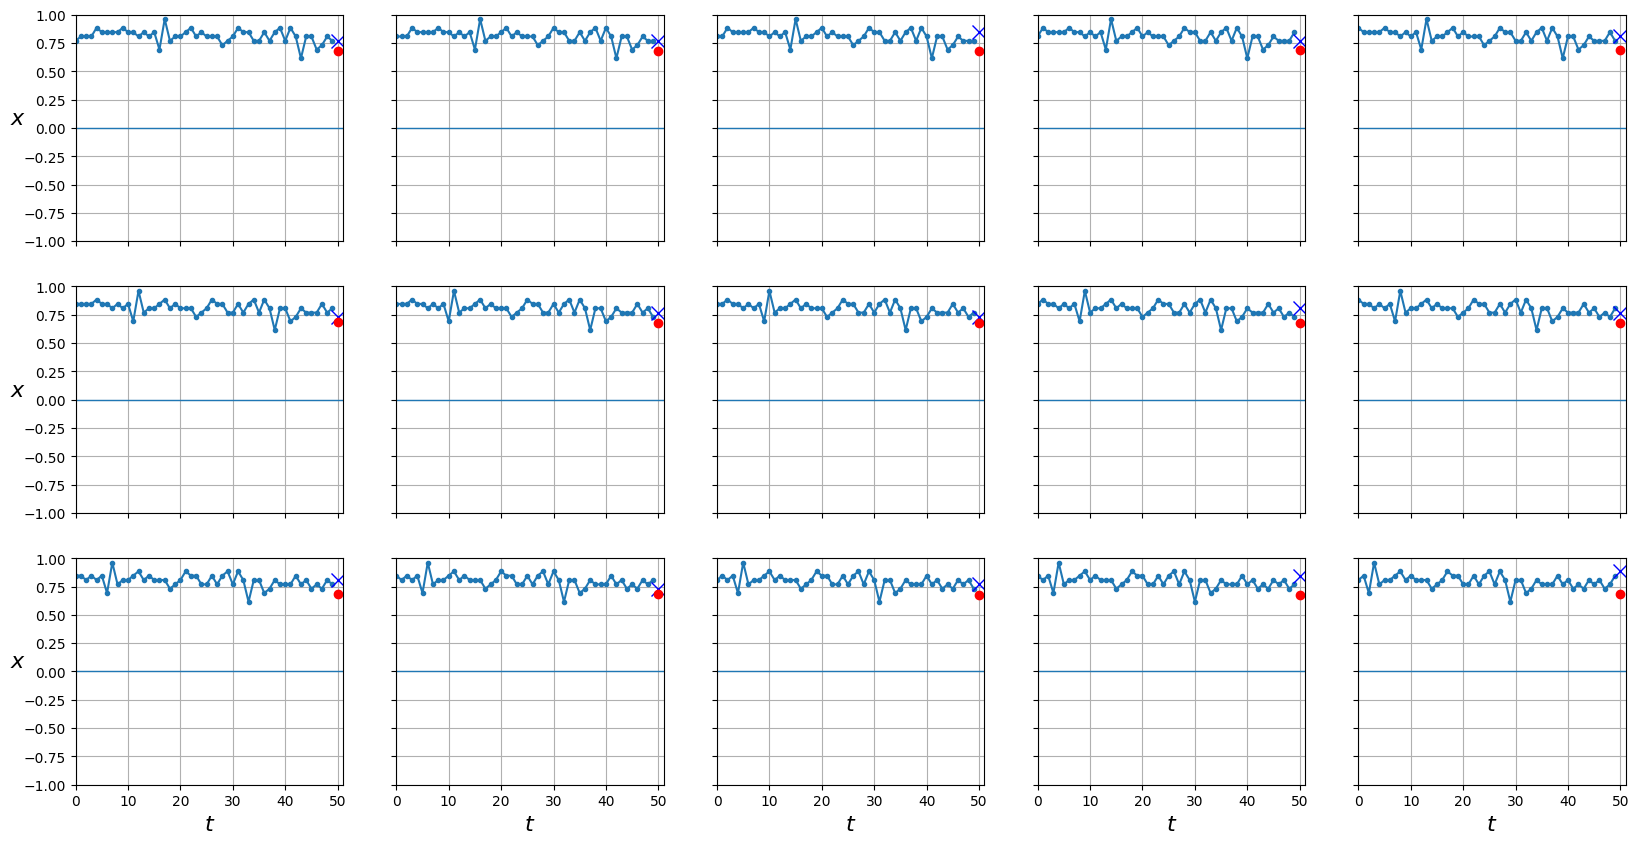

0.020536793395876884

In [114]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

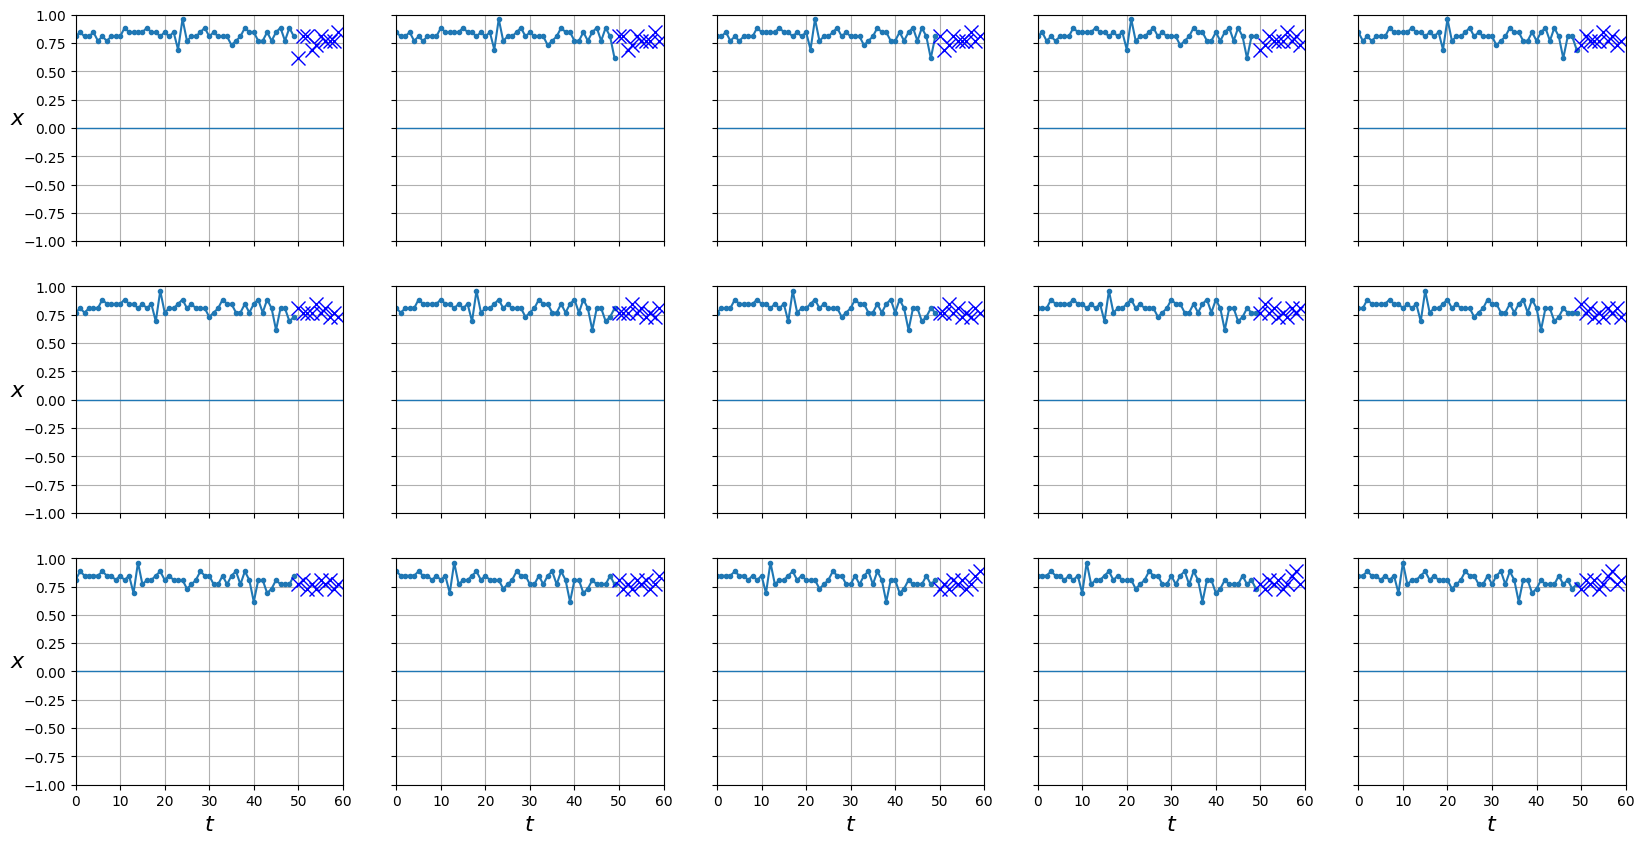

In [120]:
#预测多个值

# 设置时间步长和预测步长
time_steps = 50
prediction_steps = 10  # 1 for 1-day prediction, 5 for 5-day prediction

X, y = create_sequences(scaled_max_temp, time_steps, prediction_steps)
X = X.astype(np.float32)
y = y.astype(np.float32)

n_steps = 50
train_size = int(len(X) * 0.7)
valid_size = int(len(X) * 0.8)
X_train,X_valid, X_test = X[:train_size], X[train_size:valid_size], X[valid_size:-1]
y_train, y_valid, y_test = y[:train_size], y[train_size:valid_size], y[valid_size:-1]

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

plot_series(X_test, y_test)


